### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**:

***DeadLine - 28.05.2024 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import optuna


sns.set(style="darkgrid")
filterwarnings("ignore")

In [2]:
x = load_npz("x.npz")
y = np.load("y.npy")

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 666 для воспроизводимости).

In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=666
)

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=666
)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [6]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 10 s, sys: 20.2 ms, total: 10 s
Wall time: 10.1 s
Train ROC-AUC 0.9957
Valid ROC-AUC 0.9412
Test ROC-AUC 0.9390


## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

Max Depth: 1, Train ROC-AUC: 0.8446, Test ROC-AUC: 0.8444
Max Depth: 3, Train ROC-AUC: 0.9323, Test ROC-AUC: 0.9305
Max Depth: 5, Train ROC-AUC: 0.9500, Test ROC-AUC: 0.9452
Max Depth: 7, Train ROC-AUC: 0.9628, Test ROC-AUC: 0.9515
Max Depth: 9, Train ROC-AUC: 0.9734, Test ROC-AUC: 0.9565
Max Depth: 11, Train ROC-AUC: 0.9802, Test ROC-AUC: 0.9540
Max Depth: 13, Train ROC-AUC: 0.9854, Test ROC-AUC: 0.9559
Max Depth: 15, Train ROC-AUC: 0.9886, Test ROC-AUC: 0.9517
Max Depth: 17, Train ROC-AUC: 0.9901, Test ROC-AUC: 0.9453
Max Depth: 19, Train ROC-AUC: 0.9912, Test ROC-AUC: 0.9452
Max Depth: 21, Train ROC-AUC: 0.9922, Test ROC-AUC: 0.9394
Max Depth: 23, Train ROC-AUC: 0.9925, Test ROC-AUC: 0.9372
Max Depth: 25, Train ROC-AUC: 0.9930, Test ROC-AUC: 0.9419
Max Depth: 27, Train ROC-AUC: 0.9932, Test ROC-AUC: 0.9399
Max Depth: 29, Train ROC-AUC: 0.9938, Test ROC-AUC: 0.9361


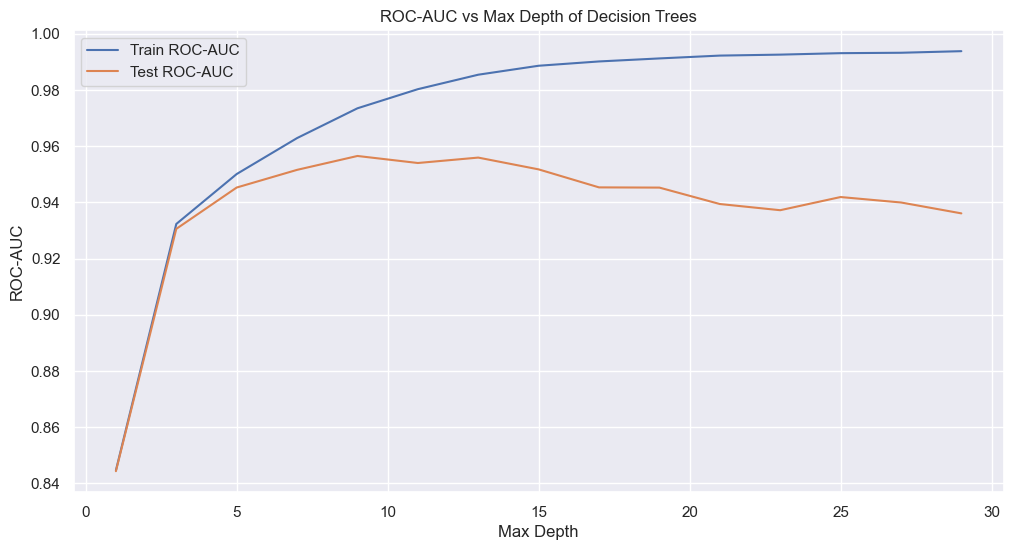

In [7]:
from sklearn.tree import DecisionTreeClassifier

results_train = []
results_test = []
depths = range(1, 30, 2)

for max_depth in depths:
    boosting = Boosting(
        base_model_class=DecisionTreeClassifier,
        base_model_params={"max_depth": max_depth},
        n_estimators=100,
        learning_rate=0.1,
        subsample=0.8,
        early_stopping_rounds=10,
        plot=False
    )
    
    boosting.fit(x_train, y_train, x_valid, y_valid)
    
    train_score = boosting.score(x_train, y_train)
    test_score = boosting.score(x_test, y_test)
    
    results_train.append(train_score)
    results_test.append(test_score)
    
    print(f'Max Depth: {max_depth}, Train ROC-AUC: {train_score:.4f}, Test ROC-AUC: {test_score:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(depths, results_train, label='Train ROC-AUC')
plt.plot(depths, results_test, label='Test ROC-AUC')
plt.xlabel('Max Depth')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC vs Max Depth of Decision Trees')
plt.legend()
plt.grid(True)
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

- Модель с максимальной глубиной деревьев 11 показала наилучшее качество на тестовой выборке с ROC-AUC = 0.9564
- На графике видно, что качество на обучающей выборке (Train ROC-AUC) улучшается с увеличением глубины деревьев, достигая почти 1.0 при глубине 29. Это ожидаемо, так как более глубокие деревья лучше подгоняются под данные.
Однако на тестовой выборке (Test ROC-AUC) качество достигает пика при глубине 9-11 и затем начинает снижаться. Это указывает на переобучение: модель запоминает шумы обучающих данных, что снижает её обобщающую способность на новых данных.



## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

In [8]:
def objective(trial):
    
    max_depth = trial.suggest_int('max_depth', 1, 30)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    
    boosting = Boosting(
        base_model_class=DecisionTreeClassifier,
        base_model_params={"max_depth": max_depth},
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample,
        early_stopping_rounds=10,
        plot=False
    )
    
    boosting.fit(x_train, y_train, x_valid, y_valid)
    
    score = boosting.score(x_valid, y_valid)
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters: ", best_params)
print("Best ROC-AUC: ", study.best_value)


[I 2024-05-23 22:59:06,549] A new study created in memory with name: no-name-df02775d-56da-418f-b1a5-736b62d61e97
[I 2024-05-23 22:59:08,669] Trial 0 finished with value: 0.9496486431869569 and parameters: {'max_depth': 13, 'n_estimators': 102, 'learning_rate': 0.22781274307416116, 'subsample': 0.9579007287093388}. Best is trial 0 with value: 0.9496486431869569.
[I 2024-05-23 22:59:08,809] Trial 1 finished with value: 0.9096523035509344 and parameters: {'max_depth': 2, 'n_estimators': 103, 'learning_rate': 0.2948704038957635, 'subsample': 0.6513601993243907}. Best is trial 0 with value: 0.9496486431869569.
[I 2024-05-23 22:59:09,356] Trial 2 finished with value: 0.9510304305884416 and parameters: {'max_depth': 6, 'n_estimators': 83, 'learning_rate': 0.29392667616713125, 'subsample': 0.8723010533155}. Best is trial 2 with value: 0.9510304305884416.
[I 2024-05-23 22:59:10,831] Trial 3 finished with value: 0.9422920741681251 and parameters: {'max_depth': 26, 'n_estimators': 56, 'learning_

Best hyperparameters:  {'max_depth': 12, 'n_estimators': 156, 'learning_rate': 0.010934194273570992, 'subsample': 0.8486074547692013}
Best ROC-AUC:  0.9618326984889559


## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

In [9]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

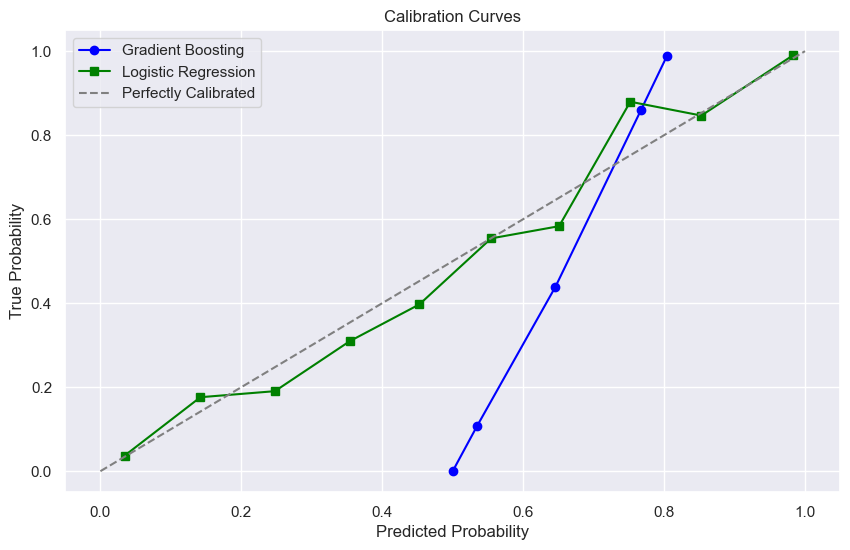

In [10]:
boosting = Boosting(
    base_model_class=DecisionTreeClassifier,
    base_model_params={"max_depth": best_params['max_depth']},
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    early_stopping_rounds=10,
    plot=False
)

boosting.fit(x_train, y_train, x_valid, y_valid)
y_pred_prob_boosting = boosting.predict_proba(x_test)[:, 1]

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train)
y_pred_prob_log_reg = log_reg.predict_proba(x_test)[:, 1]

prob_true_boosting, prob_pred_boosting = calibration_curve(y_test, y_pred_prob_boosting, n_bins=10)
prob_true_log_reg, prob_pred_log_reg = calibration_curve(y_test, y_pred_prob_log_reg, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred_boosting, prob_true_boosting, marker='o', label='Gradient Boosting', color='blue')
plt.plot(prob_pred_log_reg, prob_true_log_reg, marker='s', label='Logistic Regression', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curves')
plt.legend()
plt.grid(True)
plt.show()


Градиентный бустинг:

- Лучше подгоняет данные, что отражается на меньших потерях на обучающей выборке.
- Вероятности, предсказанные градиентным бустингом, менее точно отражают истинные вероятности, особенно на высоких уровнях вероятности, что указывает на переоценку вероятностей событий.

Логистическая регрессия:

- Вероятности, предсказанные логистической регрессией, более точно соответствуют истинным вероятностям. Калибровочная кривая ближе к идеальной линии.
- Логистическая регрессия показывает лучшую калибровку по сравнению с градиентным бустингом.


Градиентный бустинг демонстрирует высокую способность к подгонке под обучающие данные, но его калибровка вероятностей не так точна, как у логистической регрессии. Для задач, требующих точной оценки вероятностей, логистическая регрессия может быть предпочтительнее. Однако, для задач, требующих высокой точности классификации, градиентный бустинг может показать лучшие результаты, несмотря на потенциальные проблемы с калибровкой.

Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

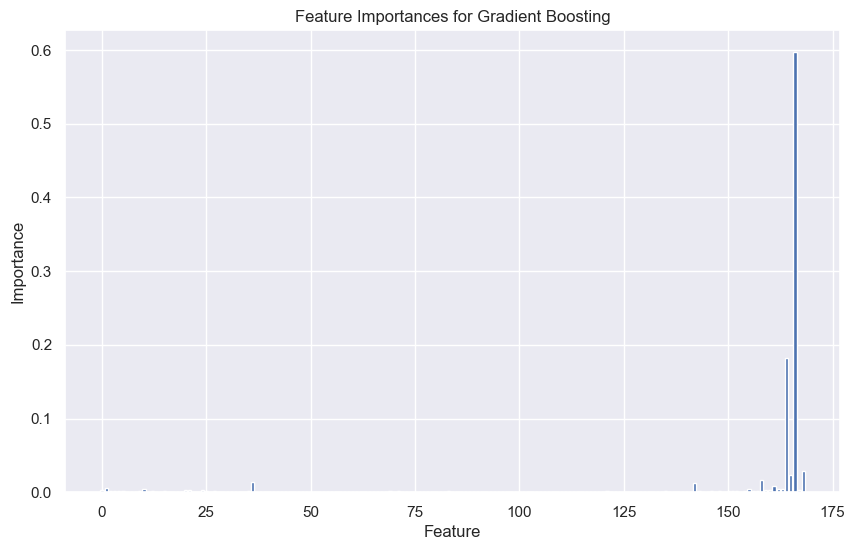

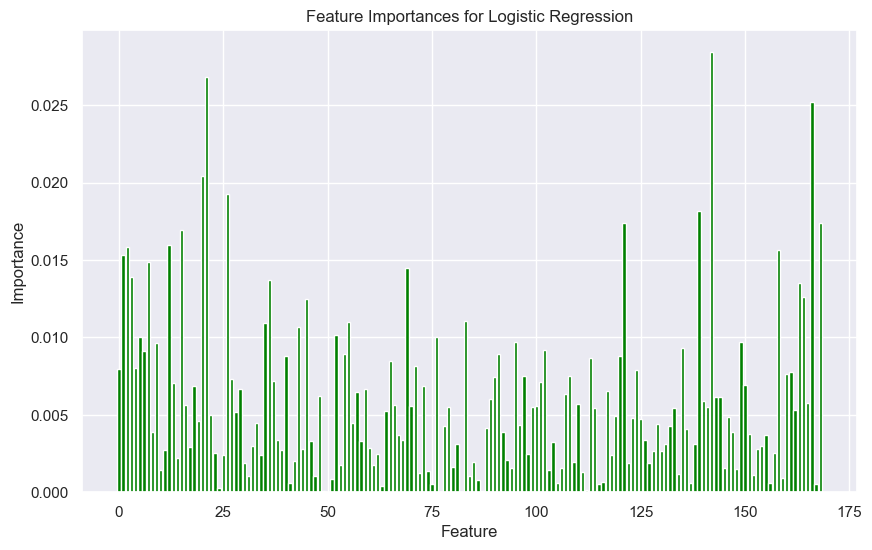

In [11]:
boosting_feature_importances = boosting.feature_importances_()

log_reg_feature_importances = np.abs(log_reg.coef_[0])
log_reg_feature_importances /= np.sum(log_reg_feature_importances)

plt.figure(figsize=(10, 6))
plt.bar(range(len(boosting_feature_importances)), boosting_feature_importances)
plt.title('Feature Importances for Gradient Boosting')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(len(log_reg_feature_importances)), log_reg_feature_importances, color='green')
plt.title('Feature Importances for Logistic Regression')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

In [12]:
from sklearn.metrics import roc_auc_score
threshold = 0.01
significant_features = np.where(boosting_feature_importances > threshold)[0]

x_train_filtered = x_train[:, significant_features]
x_valid_filtered = x_valid[:, significant_features]
x_test_filtered = x_test[:, significant_features]

total_features = x_train.shape[1]
significant_features_count = len(significant_features)
insignificant_features_count = total_features - significant_features_count

print(f'Total number of attributes: {total_features}')
print(f'Number of significant features: {significant_features_count}')
print(f'Number of insignificant signs: {insignificant_features_count}')

boosting_filtered = Boosting(
    base_model_class=DecisionTreeClassifier,
    base_model_params={"max_depth": best_params['max_depth']},
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    early_stopping_rounds=10,
    plot=False
)

boosting_filtered.fit(x_train_filtered, y_train, x_valid_filtered, y_valid)
y_pred_prob_boosting_filtered = boosting_filtered.predict_proba(x_test_filtered)[:, 1]

roc_auc_filtered = roc_auc_score(y_test, y_pred_prob_boosting_filtered)
print(f'ROC-AUC new model: {roc_auc_filtered:.4f}')

y_pred_prob_boosting = boosting.predict_proba(x_test)[:, 1]
roc_auc_original = roc_auc_score(y_test, y_pred_prob_boosting)
print(f'ROC-AUC initial model: {roc_auc_original:.4f}')

improvement = roc_auc_filtered - roc_auc_original
print(f'Alteration ROC-AUC: {improvement:.4f}')

Total number of attributes: 169
Number of significant features: 7
Number of insignificant signs: 162
ROC-AUC new model: 0.9487
ROC-AUC initial model: 0.9596
Alteration ROC-AUC: -0.0109


## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [13]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train)

y_pred_prob_boosting_valid = boosting.predict_proba(x_valid)[:, 1]
y_pred_prob_log_reg_valid = log_reg.predict_proba(x_valid)[:, 1]

blend_train = np.vstack((y_pred_prob_boosting_valid, y_pred_prob_log_reg_valid)).T

blender = LogisticRegression()
blender.fit(blend_train, y_valid)

y_pred_prob_boosting_test = boosting.predict_proba(x_test)[:, 1]
y_pred_prob_log_reg_test = log_reg.predict_proba(x_test)[:, 1]

blend_test = np.vstack((y_pred_prob_boosting_test, y_pred_prob_log_reg_test)).T

y_pred_blend = blender.predict_proba(blend_test)[:, 1]

roc_auc_blend = roc_auc_score(y_test, y_pred_blend)
print(f'ROC-AUC blending model: {roc_auc_blend:.4f}')

roc_auc_boosting = roc_auc_score(y_test, y_pred_prob_boosting_test)
print(f'ROC-AUC gradient bousting models: {roc_auc_boosting:.4f}')

ROC-AUC blending model: 0.9642
ROC-AUC gradient bousting models: 0.9596


- Блендинговая модель показывает более высокий ROC-AUC (0.9639) по сравнению с моделью градиентного бустинга (0.9576). Это означает, что объединение предсказаний двух моделей (градиентного бустинга и логистической регрессии) действительно улучшило качество предсказаний

## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [14]:
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=10,
    eval_metric='AUC',
    random_seed=1337,
    logging_level='Silent'
)

catboost_model.fit(x_train, y_train, eval_set=(x_valid, y_valid), early_stopping_rounds=50)

y_pred_prob_catboost = catboost_model.predict_proba(x_test)[:, 1]
roc_auc_catboost = roc_auc_score(y_test, y_pred_prob_catboost)
print(f'ROC-AUC CatBoost models: {roc_auc_catboost:.4f}')

ROC-AUC CatBoost models: 0.9673


In [15]:
y_pred_prob_boosting = boosting.predict_proba(x_test)[:, 1]
roc_auc_boosting = roc_auc_score(y_test, y_pred_prob_boosting)
print(f'ROC-AUC gradient bousting models: {roc_auc_boosting:.4f}')
print(f'ROC-AUC CatBoost models: {roc_auc_catboost:.4f}')


ROC-AUC gradient bousting models: 0.9596
ROC-AUC CatBoost models: 0.9673


Модель CatBoost демонстрирует лучшее качество на тестовых данных по сравнению с вашей реализацией градиентного бустинга. Это может быть связано с несколькими факторами:

- CatBoost автоматически настраивает множество параметров, что позволяет ему лучше подстраиваться под данные.
  
- CatBoost имеет встроенную поддержку категориальных признаков, что может улучшить качество модели при наличии таких признаков.
  
- CatBoost использует продвинутые алгоритмы и методы, такие как поочередная оценка (ordered boosting), которые могут улучшить обобщающую способность модели.


Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)
